In [1]:
import numpy as np
import pandas as pd
import sklearn as ktl
import pickle
import matplotlib.pylab as plt
import seaborn

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor

from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB

In [2]:
bol = pd.read_csv("/Users/hendrixperalta/Desktop/bolivia/data/GeoDS4Bolivia.csv")
bol = bol.rename(columns={"asdf_id":"id"})

#list(bol.columns)
offset = 1000000  
sat = pd.read_csv("data/egdp/satelite_data.csv")
sat["lnEGDPpc2012"] = np.log((sat["egdp2012"]/ bol["pop2012"])+offset)


df = pd.merge(bol, sat, on="id", how="outer")


df["total_land2012"] = df["agr_land2012"] + df["urb_land2012"]
df["perUrb_land"] = df["urb_land2012"] / df["total_land2012"]
df["ln_perUrb_land"] = np.log(df["perUrb_land"].fillna(0) + offset)

df["ln_tr400_pop2012"] = np.log(df["tr400_pop2012"])

df["ln_pm25_2012"] = np.log(df["pm25_2012"])

df["ln_land_temp2012"] = np.log(df["land_temp2012"])

# **Data exploration**

In [3]:
short_df = df[["imds","ln_t400NTLpc2012", "ln_tr400_pop2012", 'lnEGDPpc2012', 'ln_perUrb_land', 'pm25_2012', 'land_temp2012', "urb_land2012","agr_land2012"]]
short_df.isna().sum()

imds                0
ln_t400NTLpc2012    0
ln_tr400_pop2012    0
lnEGDPpc2012        0
ln_perUrb_land      0
pm25_2012           0
land_temp2012       0
urb_land2012        0
agr_land2012        0
dtype: int64

In [4]:
print(df[["agr_land2012", "urb_land2012"]])

     agr_land2012  urb_land2012
0        0.000000      0.000000
1        0.000000      0.000000
2        0.000000      0.000000
3       50.276154    195.118281
4        0.000000      0.000000
..            ...           ...
334      0.000000      1.254882
335      8.085184      0.000000
336     29.080455      0.000000
337      0.000000    320.778602
338     47.023029     16.002446

[339 rows x 2 columns]


In [5]:
short_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339 entries, 0 to 338
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   imds              339 non-null    float64
 1   ln_t400NTLpc2012  339 non-null    float64
 2   ln_tr400_pop2012  339 non-null    float64
 3   lnEGDPpc2012      339 non-null    float64
 4   ln_perUrb_land    339 non-null    float64
 5   pm25_2012         339 non-null    float64
 6   land_temp2012     339 non-null    float64
 7   urb_land2012      339 non-null    float64
 8   agr_land2012      339 non-null    float64
dtypes: float64(9)
memory usage: 24.0 KB


In [6]:
short_df.describe()

,imds,ln_t400NTLpc2012,ln_tr400_pop2012,lnEGDPpc2012,ln_perUrb_land,pm25_2012,land_temp2012,urb_land2012,agr_land2012
count,339.000000,339.000000,339.000000,3.390000e+02,3.390000e+02,339.000000,339.000000,339.000000,339.000000
mean,51.050442,13.033028,9.335445,1.381551e+01,1.381551e+01,23.561684,297.836346,358.185120,85.317092
std,6.771824,1.671621,1.145385,1.812101e-08,3.458818e-07,6.765622,3.453744,2435.344248,334.547755
min,35.700001,0.856095,6.251161,1.381551e+01,1.381551e+01,8.257901,287.125211,0.000000,0.000000
25%,47.000000,12.050438,8.686743,1.381551e+01,1.381551e+01,18.052961,295.856684,0.000000,0.000000
50%,50.500000,13.118243,9.294614,1.381551e+01,1.381551e+01,21.915591,298.305783,0.000000,5.356337
75%,54.850001,14.268402,9.903637,1.381551e+01,1.381551e+01,28.731712,300.579665,21.065371,27.980859
max,80.199997,17.071051,14.171911,1.381551e+01,1.381551e+01,38.466365,305.141851,27738.443240,3334.302280


In [7]:
missing_labels = df.columns[df.isna().any()]
missing_labels

Index(['sdg1_1_eepr', 'sdg2_4_pual', 'sdg2_4_td', 'sdg5_5_gpop', 'sdg8_4_rem',
       'sdg9_5_eutf', 'sdg10_2_iec', 'sdg1_1_dtl_abs', 'sdg2_4_apu_abs',
       'sdg2_4_tm_abs', 'sdg3_1_udhf_ab', 'sdg8_4_rem_abs', 'sdg9_5_eutf_abs',
       'ln_NTLpc2012', 'ln_NTLpc2013', 'ln_NTLpc2014', 'ln_NTLpc2015',
       'ln_NTLpc2016', 'ln_NTLpc2017', 'ln_NTLpc2018', 'ln_NTLpc2019',
       'ln_NTLpc2020', 'perUrb_land'],
      dtype='object')

In [8]:
#plt.style.available

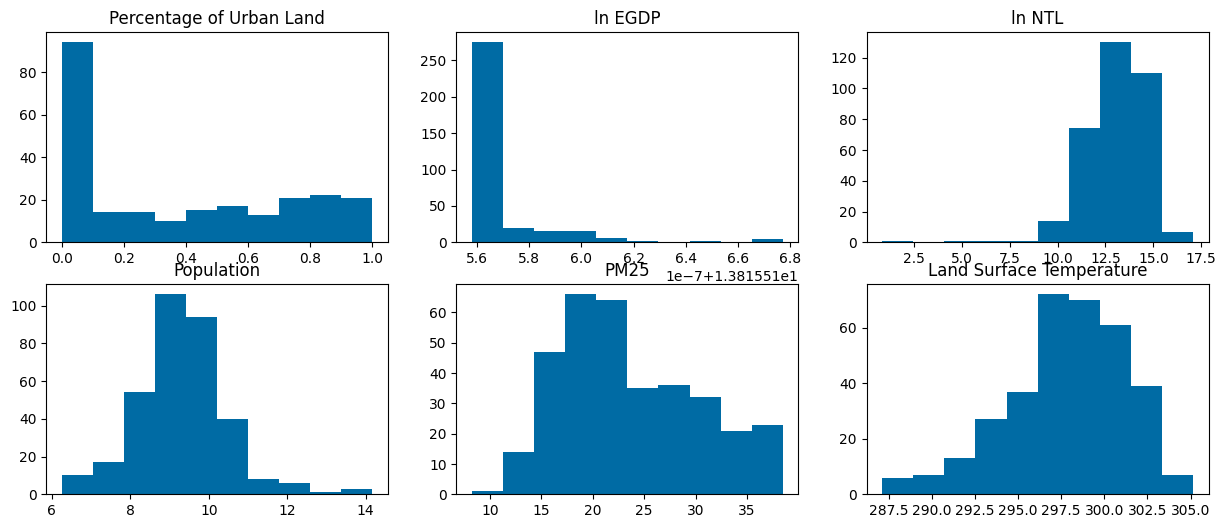

In [9]:
plt.style.use("tableau-colorblind10")

fig, ((ax0, ax1, ax2),(ax3, ax4, ax5)) = plt.subplots(nrows=2,
                                                     ncols=3,
                                                     figsize=(15,6)
                                                     )
ax0.hist(df["perUrb_land"])
ax0.set(title="Percentage of Urban Land")

ax1.hist(df["lnEGDPpc2012"])
ax1.set(title="ln EGDP")

ax2.hist(df["ln_t400NTLpc2012"])
ax2.set(title="ln NTL")

ax3.hist(df["ln_tr400_pop2012"])
ax3.set(title= "Population")

ax4.hist(df["pm25_2012"])
ax4.set(title= "PM25")

ax5.hist(df["land_temp2012"])
ax5.set(title= "Land Surface Temperature");


[Text(0.5, 1.0, 'ln EGDP')]

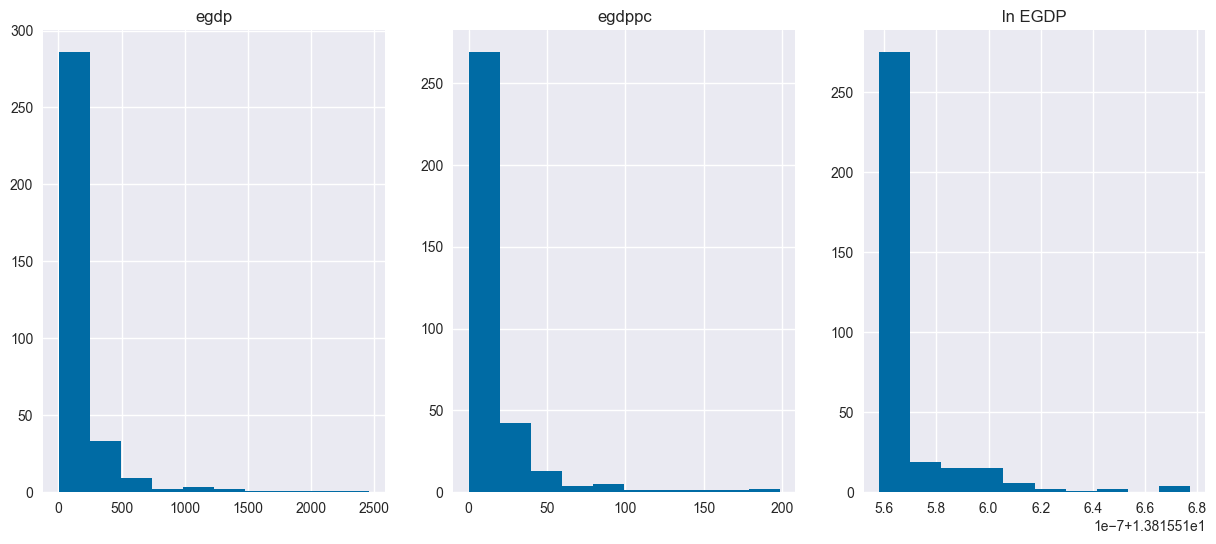

In [94]:
plt.style.use("tableau-colorblind10")

fig, (ax0, ax1, ax2) = plt.subplots(nrows=1,
                                                     ncols=3,
                                                     figsize=(15,6)
                                                     )
ax0.hist(sat["egdp2012"])
ax0.set(title="egdp")

ax1.hist(sat["egdp2012"]/df["ln_tr400_pop2012"])
ax1.set(title= "egdppc")

ax2.hist(df["lnEGDPpc2012"])
ax2.set(title="ln EGDP")


In [90]:
#plt.style.available

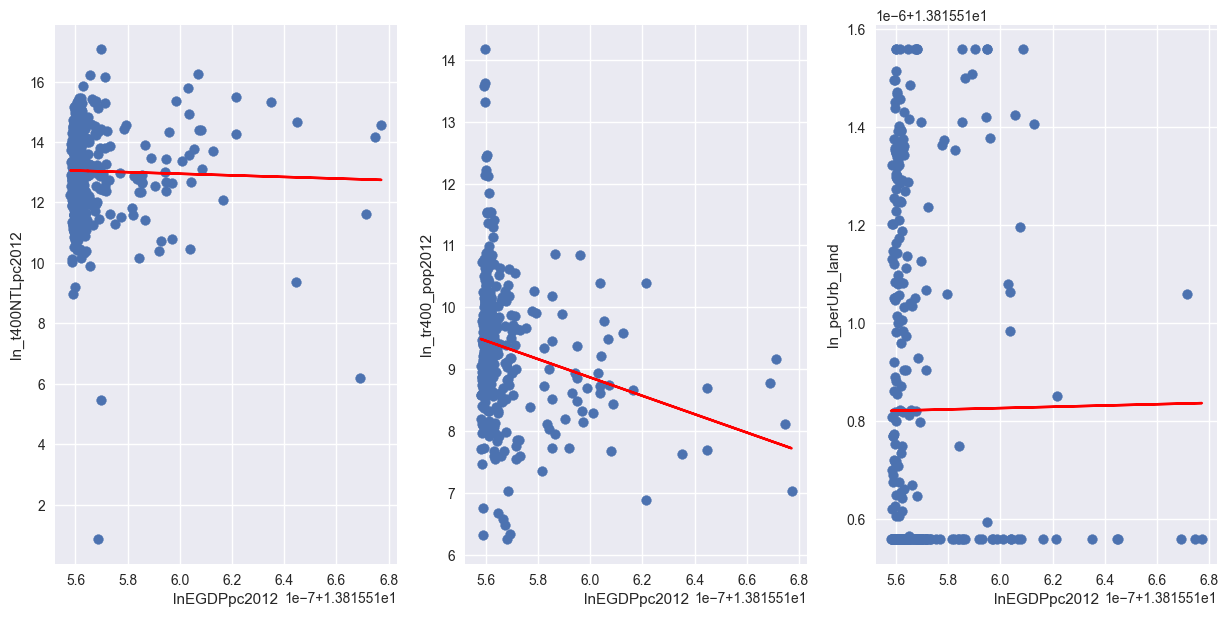

In [85]:
plt.style.use("seaborn-v0_8")

fig, (ax0, ax1, ax2) = plt.subplots(nrows=1,
                                    ncols=3,
                                    figsize=(15,7))
#----- ax0
ax0.scatter(x=short_df['lnEGDPpc2012'], y=short_df["ln_t400NTLpc2012"])
ax0.set(xlabel="lnEGDPpc2012", ylabel="ln_t400NTLpc2012")

# add trendline
z = np.polyfit(short_df["lnEGDPpc2012"], short_df['ln_t400NTLpc2012'], 1)
p = np.poly1d(z)
ax0.plot(short_df["lnEGDPpc2012"],p(short_df["lnEGDPpc2012"]),"r-")

#----- ax1
ax1.scatter(x=short_df["lnEGDPpc2012"], y=short_df['ln_tr400_pop2012'])
ax1.set(xlabel="lnEGDPpc2012", ylabel="ln_tr400_pop2012")

# add trendline
z = np.polyfit(short_df["lnEGDPpc2012"], short_df['ln_tr400_pop2012'], 1)
p = np.poly1d(z)
ax1.plot(short_df["lnEGDPpc2012"],p(short_df["lnEGDPpc2012"]),"r-")

#----- ax2
ax2.scatter(x=short_df["lnEGDPpc2012"], y=short_df['ln_perUrb_land'])
ax2.set(xlabel="lnEGDPpc2012", ylabel="ln_perUrb_land")

# add trendline
z = np.polyfit(short_df["lnEGDPpc2012"], short_df['ln_perUrb_land'], 1)
p = np.poly1d(z)
ax2.plot(short_df["lnEGDPpc2012"],p(short_df["lnEGDPpc2012"]),"r-")



In [86]:
egdp_ntl = short_df["lnEGDPpc2012"].corr(short_df['ln_t400NTLpc2012'])
egdp_pop = short_df["lnEGDPpc2012"].corr(short_df['ln_tr400_pop2012'])
egdp_urb = short_df["lnEGDPpc2012"].corr(short_df['ln_perUrb_land'])

print(f"Correlation of egdp and ntl: {egdp_ntl}")
print(f"Correlation of egdp and pop: {egdp_pop}")
print(f"Correlation of egdp and Urban land %: {egdp_urb}")

Correlation of egdp and ntl: -0.02846899084988478
Correlation of egdp and pop: -0.23478495314577078
Correlation of egdp and Urban land %: 0.006909208607553821


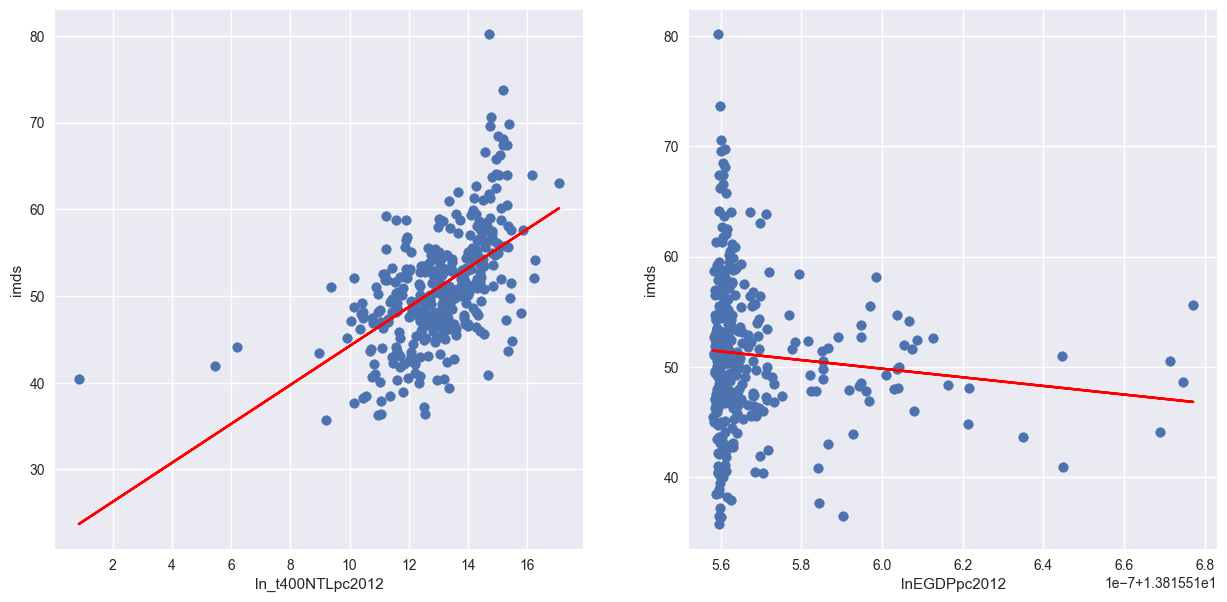

In [89]:

fig, (ax1, ax2) = plt.subplots(nrows=1,
                                    ncols=2,
                                    figsize=(15,7))

#----- ax1
ax1.scatter(x=short_df["ln_t400NTLpc2012"], y=short_df['imds'])
ax1.set(xlabel="ln_t400NTLpc2012", ylabel="imds")

# add trendline
z = np.polyfit(short_df["ln_t400NTLpc2012"], short_df['imds'], 1)
p = np.poly1d(z)
ax1.plot(short_df["ln_t400NTLpc2012"],p(short_df["ln_t400NTLpc2012"]), "r-")

#----- ax2
ax2.scatter(x=short_df["lnEGDPpc2012"], y=short_df['imds'])
ax2.set(xlabel="lnEGDPpc2012", ylabel="imds");

# add trendline
z = np.polyfit(short_df["lnEGDPpc2012"], short_df['imds'], 1)
p = np.poly1d(z)
ax2.plot(short_df["lnEGDPpc2012"], p(short_df["lnEGDPpc2012"]), "r-")

In [87]:
ntl_imds = short_df["ln_t400NTLpc2012"].corr(short_df['imds'])
egdp_imds = short_df["lnEGDPpc2012"].corr(short_df['imds'])

print(f"Correlation of ntl and egdp: {ntl_egdp}")
print(f"Correlation of ntl and imds: {ntl_imds}")
print(f"Correlation of egdp and imds: {egdp_imds}")

Correlation of ntl and imds: 0.5548280194761073
Correlation of egdp and imds: -0.10475268579773032


# **Regression models**

### Linear model

In [10]:
x = df[["ln_t400NTLpc2012", "ln_tr400_pop2012", 'lnEGDPpc2012', 'perUrb_land', 'ln_pm25_2012', 'ln_land_temp2012']].fillna(0)
y = df['imds']

np.random.seed(42)
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2) 

model = LinearRegression()
model.fit(x_train,y_train)
lr = model.score(x_test, y_test)

y_pred = model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

#print("Mean Squared Error:", mse)
#print("R^2 Score:", r2)

### Ridge  model

In [11]:

np.random.seed(42)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

rid_model = linear_model.Ridge()
rid_model.fit(x_train, y_train)
ri = rid_model.score(x_test, y_test)

### Random Forest Regressor model

In [12]:

np.random.seed(42)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

rf_model = RandomForestRegressor()
rf_model.fit(x_train, y_train)
rf = rf_model.score(x_test, y_test)

### Results 

In [13]:
print("R2 for the regressor models")
print(f" Linear model: {lr*100:.2f}%")
print(f" Ridger model: {ri*100:.2f}%")
print(f" Random Forest model: {rf*100:.2f}%")

R2 for the regressor models
 Linear model: 47.56%
 Ridger model: 47.32%
 Random Forest model: 60.65%


# **Categorical analysis**

In [14]:
quantile_labels = ["low", 'medium-low', 'medium-high', 'high']
df["imds_quantile"] = pd.qcut(df["imds"], q=4, labels=quantile_labels)
#df["imds_quantile"]

In [15]:
x = df[["ln_t400NTLpc2012", "ln_tr400_pop2012", 'lnEGDPpc2012', 'perUrb_land', 'ln_pm25_2012', 'ln_land_temp2012']].fillna(0)
y = df['imds_quantile']

np.random.seed(42)
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2) 

clf = RandomForestClassifier()
#clf.get_params()
clf.fit(x_train,y_train);

y_preds = clf.predict(x_test)

#evaluate the model
#print(f" Train data score: {clf.score(x_train, y_train)*100:.2f}%")
print(f" Test data score: {clf.score(x_test, y_test)*100:.2f}%")
rf_cl = clf.score(x_test, y_test)

 Test data score: 41.18%


In [16]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

        high       0.52      0.67      0.59        18
         low       0.40      0.67      0.50        15
 medium-high       0.14      0.06      0.08        18
  medium-low       0.38      0.29      0.33        17

    accuracy                           0.41        68
   macro avg       0.36      0.42      0.37        68
weighted avg       0.36      0.41      0.37        68



In [17]:
print(confusion_matrix(y_test, y_preds))

[[12  3  2  1]
 [ 0 10  1  4]
 [ 9  5  1  3]
 [ 2  7  3  5]]


In [18]:
accuracy_score(y_test, y_preds)

0.4117647058823529

In [19]:
# improve model

np.random.seed(42)
for i in range(10, 100, 10):
    print(f"Trying model with {i} stimators")
    clf = RandomForestClassifier(n_estimators=i).fit(x_train, y_train)
    print(f"Model acurracy is {clf.score(x_test, y_test)*100:.2f}%")

Trying model with 10 stimators
Model acurracy is 50.00%
Trying model with 20 stimators
Model acurracy is 42.65%
Trying model with 30 stimators
Model acurracy is 39.71%
Trying model with 40 stimators
Model acurracy is 42.65%
Trying model with 50 stimators
Model acurracy is 47.06%
Trying model with 60 stimators
Model acurracy is 45.59%
Trying model with 70 stimators
Model acurracy is 36.76%
Trying model with 80 stimators
Model acurracy is 45.59%
Trying model with 90 stimators
Model acurracy is 42.65%


In [20]:
#pickle.dump(clf, open("random_forest_model.pkl", "wb"))

#load_model = pickle.load(open("random_forest_model.pkl", "rb"))
#load_model.score(x_test, y_test)

### Linear SVC Classifier

In [21]:
np.random.seed(42)
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2) 

sgd_cla = svm.LinearSVC(dual="auto", max_iter=10000)
sgd_cla.fit(x_train, y_train)
sgd_cl = sgd_cla.score(x_test, y_test)

### Naive Bayes Classifier

In [22]:
np.random.seed(42)
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2) 

naive_cla = GaussianNB()
naive_cla.fit(x_train, y_train)
naive_cl = naive_cla.score(x_test, y_test)

### Results 

In [23]:
print("R2 for the classifier models")
print(f" Random Forest model: {rf_cl*100:.2f}%")
print(f" Linear SVC model: {sgd_cl*100:.2f}%")
print(f" Naive Bayes model: {naive_cl*100:.2f}%")

R2 for the classifier models
 Random Forest model: 41.18%
 Linear SVC model: 45.59%
 Naive Bayes model: 48.53%


## Iterate regression models

In [29]:
y_variables = list(df.columns)
del y_variables[195:427]
del y_variables[10:13]
del y_variables[0:8]

### Linear Regression

In [52]:
#y_variables

In [46]:
xs = [ "ln_t400NTLpc2012", "ln_tr400_pop2012", 'lnEGDPpc2012', 'ln_perUrb_land','ln_pm25_2012', 'land_temp2012']
for x in xs:
    df.fillna({x:0}, inplace=True)

In [47]:
model_results = {}

for y_variable in y_variables:
    filtered_df = df.dropna()

    x = filtered_df[[ "ln_t400NTLpc2012", "ln_tr400_pop2012", 'lnEGDPpc2012', 'ln_perUrb_land', 'ln_pm25_2012', 'ln_land_temp2012']]
    y = filtered_df[y_variable]

    np.random.seed(42)
    x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2) 

    model = LinearRegression()
    model.fit(x_train,y_train)

    y_pred = model.predict(x_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    model_results[y_variable] = r2

res_90 = {key: value for key, value in model_results.items() if value > 0.9}
res_80 = {key: value for key, value in model_results.items() if (value > 0.8 and value < 0.9)}
res_70 = {key: value for key, value in model_results.items() if (value > 0.7 and value < 0.8)}

res_neg = {key: value for key, value in model_results.items() if value < 0}

#    print(f"For the variable {y_variable} Mean Squared Error:", mse)
#    print("R^2 Score:", r2)


In [48]:
res_90

{}

In [49]:
res_80

{}

In [50]:
res_70

{'sdg8_5_ompr_abs': 0.7037518702068086, 'sdg8_5_ofpr_abs': 0.7380383281390457}

In [51]:
res_neg

{'sdg2_4_td': -0.6065228677614354,
 'sdg3_3_cdir': -0.03358787213365089,
 'sdg4_c_qti': -0.018828197475750708,
 'sdg4_c_qts': -0.04171088664313061,
 'sdg6_1_dwc': -0.014197034485673221,
 'sdg7_1_ec': -0.019096155220245548,
 'sdg8_6_mlm': -0.09156463654423685,
 'sdg9_5_eutf': -0.01723942575911419,
 'sdg10_2_gcye': -0.06304538751990219,
 'sdg11_2_samt': -0.18191534753243133,
 'sdg13_2_dra': -0.004398701723062448,
 'sdg17_5_pipc': -0.251831217422255,
 'sdg3_3_cd_abs': -0.625534792652011,
 'sdg9_5_kcd_abs': -0.14042406989570821,
 'sdg2_4_td_norm': -0.5609332023587519,
 'sdg3_3_cdir_norm': -0.044045775742800775,
 'sdg4_c_qti_norm': -0.01878773188363425,
 'sdg4_c_qts_norm': -0.04163423451094972,
 'sdg5_1_gpsd_norm': -0.5995529667442347,
 'sdg7_1_ec_norm': -0.04909495482452364,
 'sdg8_6_mlm_norm': -0.12345809479315073,
 'sdg10_2_gcye_norm': -0.05242228465467336,
 'sdg17_5_pipc_norm': -0.23937317794923563}

### Random Forest Regressor

In [41]:
model_results = {}

for y_variable in y_variables:
    filtered_df = df.dropna()

    x = filtered_df[[ "ln_t400NTLpc2012", "ln_tr400_pop2012", 'lnEGDPpc2012', 'ln_perUrb_land',  "ln_pm25_2012", "ln_land_temp2012"]].fillna(0)
    y = filtered_df[y_variable]

    np.random.seed(42)
    x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2) 

    model = RandomForestRegressor()
    model.fit(x_train,y_train)

    y_pred = model.predict(x_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    model_results[y_variable] = r2

res_90 = {key: value for key, value in model_results.items() if value > 0.9}
res_80 = {key: value for key, value in model_results.items() if (value > 0.8 and value < 0.9)}
res_70 = {key: value for key, value in model_results.items() if (value > 0.7 and value < 0.8)}

res_neg = {key: value for key, value in model_results.items() if value < 0}

#    print(f"For the variable {y_variable} Mean Squared Error:", mse)
#    print("R^2 Score:", r2)


In [42]:
res_90

{'sdg8_5_ompr_abs': 0.9770750823048564,
 'sdg8_5_ofpr_abs': 0.911908736145733,
 'sdg8_6_wlm_abs': 0.9040380073555699}

In [43]:
res_80

{'sdg1_1_pubn_abs': 0.8547197666129325,
 'sdg2_4_tm_abs': 0.8911990704715613,
 'sdg11_1_ho_abs': 0.8036498045971061,
 'sdg16_6_aob_abs': 0.8616799563060358}

In [44]:
res_70

{'sdg8_11_idi': 0.794011121987113,
 'sdg2_2_cm_abs': 0.7709523486735997,
 'sdg3_2_fb_abs': 0.7079920761078472,
 'sdg3_2_ffb_abs': 0.7279496040075304,
 'sdg3_7_bpw_abs': 0.798714726306464,
 'sdg4_1_mhs_abs': 0.7481149371624239,
 'sdg4_4_heu_abs': 0.7664603231326786,
 'sdg8_6_mlm_abs': 0.7502177721444483,
 'sdg8_10_dbb_abs': 0.7718779170833012,
 'sdg9_c_hf_abs': 0.7914621048549926,
 'sdg16_9_ncr_abs': 0.7015345160571913,
 'sdg8_11_idi_norm': 0.7948149367176824}

In [45]:
res_neg 

{'sdg3_3_cdir': -0.43981977351243606,
 'sdg3_3_di': -0.19755341165376383,
 'sdg4_1_ssdrm': -0.12874848801895467,
 'sdg4_1_ssdrf': -0.03805444393425317,
 'sdg4_c_qti': -0.11610087898557397,
 'sdg5_1_gpsd': -0.5785668755618496,
 'sdg6_1_dwc': -0.007767903351779681,
 'sdg6_3_wwt': -0.0005860855375370289,
 'sdg8_6_mlm': -0.06813997325969146,
 'sdg9_5_cd': -0.2460688020609696,
 'sdg11_2_samt': -6.100126254579494,
 'sdg13_2_tco2e': -0.06984157942387936,
 'sdg15_5_blr': -0.14299313567739325,
 'sdg16_6_pbec': -0.02898092202703939,
 'sdg17_5_pipc': -0.015025668871373465,
 'sdg3_3_cd_abs': -30.118169637630263,
 'sdg3_3_pd_abs': -0.1024264323647135,
 'sdg6_2_bsc_abs': -0.14877545344992127,
 'sdg9_5_kcd_abs': -0.15949739294917897,
 'sdg9_c_tr_abs': -0.7362610834954388,
 'sdg11_2_mtv_abs': -1.7196574168670216,
 'sdg13_2_ad_abs': -0.006957769803694225,
 'sdg3_3_cdir_norm': -0.343468614443035,
 'sdg4_1_ssdrm_norm': -0.02526278247511371,
 'sdg4_c_qti_norm': -0.1030539597886686,
 'sdg5_1_gpsd_norm': -0

In [ ]:
#y_variables.index('perUrb_land')

## Getting data ready

2. handling missing values
3. converting non-num in to num variables (encoding)